# California Housing Prices

Housing price is determined by a variety of factors including but not limited to location, median income, building age, and ocean proximity. It can be helpful to determine a mathematical model to accurately predict housing price based on these variables; real estate companies can use the outputs of the system to decide whether to invest in an area. 

This dataset contains thousands of houses from the 1990 California census. In this notebook, I will fit three types of regression to the data: linear, decision tree, and random forest. 

In [38]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # graphing data
import os

housing = pd.read_csv("/content/housing.csv")
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [39]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [40]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


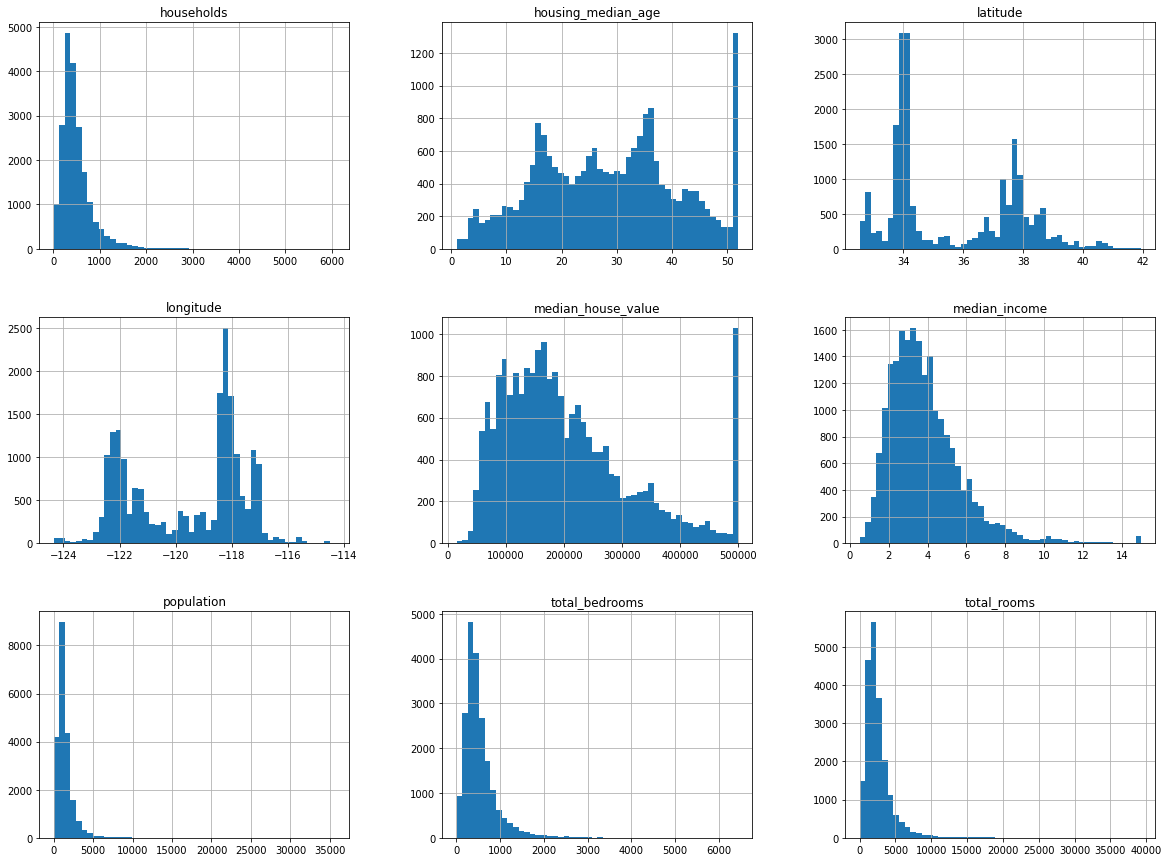

In [41]:
%matplotlib inline
housing.hist(bins=50, figsize=(20,15))
plt.show()

### Observations
* The median_income attribute has been preprocessed. It has been scaled and capped at 15.0001 for higher median incomes, and at 0.4999 for lower median incomes. A number represents roughly tens of thousands of dollars. 
* housing_median_age and median_house_value were also capped. This may be a problem as it is what we are trying to predict. 
* All the attributes have very different scales. This will require feature scaling later on. 
* Many of the histograms are tail-heavy. They extend much farther to the right of the median than to the left. We will try to transform these into bell-shaped distributions. 

### Stratified split of data

You want to avoid sampling bias. When a polling company surveys a population, they don't just pick random people out of a phonebook. They try to ensure that their population is representative of the entire US population. For example, 50.8% of Americans are female, 49.2% are male. Out of the, as an example, 1000 people, 508 should be female and 492 should be male. This is called stratified sampling. Each subgroup is called strata. 

#### Using median_income attribute

Median income is a very important attribute in predicting housing prices. You would then want to ensure that the test set is representative of the various categories of incomes in the whole dataset. 

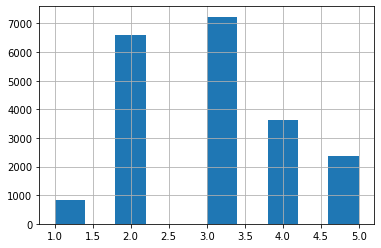

In [42]:
housing["income_cat"] = pd.cut(housing["median_income"], 
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels = [1, 2, 3, 4, 5])

housing["income_cat"].hist()

In [0]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [0]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

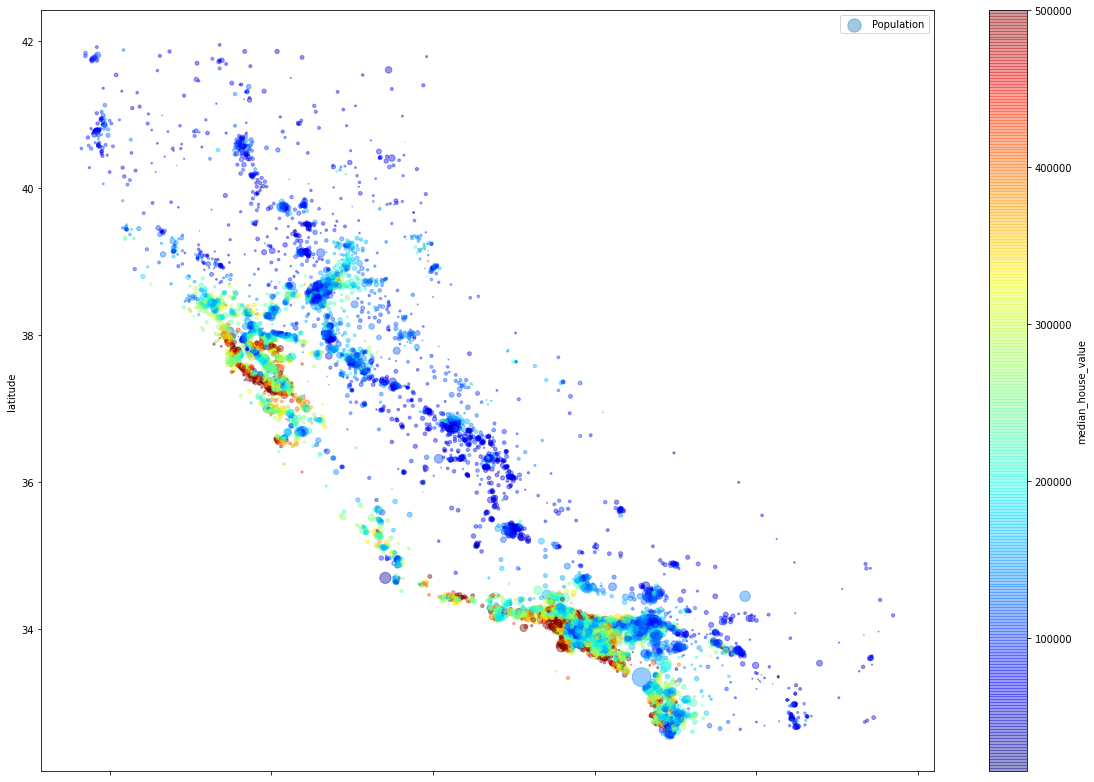

In [45]:
housing = strat_train_set.copy()
housing_labels = strat_train_set["median_house_value"].copy()
housing.plot(kind="scatter", 
             x="longitude",
             y="latitude",
             alpha=0.4, 
             s=housing["population"]/100, 
             label="Population",
             figsize=(20,14),
             c="median_house_value", 
             cmap=plt.get_cmap("jet"),
             colorbar=True)

plt.legend()

This graph shows the location and price of houses. It expectedly looks like the shape of California. It seems that the closer houses are to the ocean, the more expensive they are. 

In [46]:
corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

These are the correlation coefficients for each regressor to the regressand. Median income has an r value of 0.68. 

### Data Cleaning

When an attribute has some missing values, you have three options: 

1. Get rid of the corresponding entries
2. Get rid of the whole attribute
3. Set the values to some value ( zero, the mean, the median, etc.)

### SimpleImputer

The simple imputer function makes use of the third method. In this dataset, I will set replace missing values with the median value of the corresponding variable. 

In [0]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set['median_house_value'].copy()

In [0]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median')
housing_num = housing.drop('ocean_proximity', axis=1)
imputer.fit(housing_num)
X = imputer.transform(housing_num)
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index)

In [49]:
housing_cat = housing[['ocean_proximity']]
housing_cat.head()

,ocean_proximity
17606,<1H OCEAN
18632,<1H OCEAN
14650,NEAR OCEAN
3230,INLAND
3555,<1H OCEAN


In [50]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

For categorical variables, we need to convert to some type of number in order to fit a mathematical equation to them. One commonly used method to accomplish this is one-hot encoding. For each category, an array initialized with zeros is created. Each zero corresponds to one category. When a house is "INLAND," its zero will be turned into a one, and so on. 

In [51]:
from sklearn.base import BaseEstimator, TransformerMixin

# index of columns we are interested in
rooms_idx, bedrooms_idx, population_idx, households_idx = 3, 4, 5, 6

# Needs 3 functions to be defined without *args or **kwargs
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    
    # Function 1
    def __init__(self, add_bedrooms_per_room=True): 
        self.add_bedrooms_per_room = add_bedrooms_per_room
    
    # Function 2
    def fit(self, X, y=None):
        return self # nothing to do here
    
    # Function 3 : Adding the features we tried out earlier
    def transform(self, X):
        rooms_per_household = X[:,rooms_idx]/X[:,households_idx]
        population_per_household = X[:, population_idx]/X[:, households_idx]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:,bedrooms_idx]/X[:,rooms_idx]
            return np.c_[X, rooms_per_household,population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X,rooms_per_household,population_per_household]
        
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)
housing_extra_attribs = pd.DataFrame(housing_extra_attribs,
                                     columns=list(housing.columns) + ["rooms_per_household", "population_per_household"],
                                     index=housing.index)

housing_extra_attribs.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,population_per_household
17606,-121.89,37.29,38,1568,351,710,339,2.7042,<1H OCEAN,4.62537,2.0944
18632,-121.93,37.05,14,679,108,306,113,6.4214,<1H OCEAN,6.00885,2.70796
14650,-117.2,32.77,31,1952,471,936,462,2.8621,NEAR OCEAN,4.22511,2.02597
3230,-119.61,36.31,25,1847,371,1460,353,1.8839,INLAND,5.23229,4.13598
3555,-118.59,34.23,17,6592,1525,4459,1463,3.0347,<1H OCEAN,4.50581,3.04785


Above, we added two categories: rooms_per_household and population_per_household. These are combinatory attributes that better explain the relationships between rooms, households, and population. By themselves, they have less than significance than a more descriptive variable such as population_per_household. 

In [0]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler # For feature scaling so that all numeric attributes are in the same range

numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")), # First Do this
    ('attribs_adder', CombinedAttributesAdder()), # Next Do this
    ('std_scaler', StandardScaler()), # Finally do this
])

housing_num_tr = numeric_pipeline.fit_transform(housing_num)

In [53]:
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
    ("num", numeric_pipeline, num_attribs), # One pipeline for numeric data
    ("cat", OneHotEncoder(), cat_attribs), # One pipeline for categorical data
])

housing_prepared = full_pipeline.fit_transform(housing) # One pipeline to rule them all ;) 
housing.shape, housing_prepared.shape
housingdf = pd.DataFrame(housing_prepared)
housingdf

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,-1.156043,0.771950,0.743331,-0.493234,-0.445438,-0.636211,-0.420698,-0.614937,-0.312055,-0.086499,0.155318,1.0,0.0,0.0,0.0,0.0
1,-1.176025,0.659695,-1.165317,-0.908967,-1.036928,-0.998331,-1.022227,1.336459,0.217683,-0.033534,-0.836289,1.0,0.0,0.0,0.0,0.0
2,1.186849,-1.342183,0.186642,-0.313660,-0.153345,-0.433639,-0.093318,-0.532046,-0.465315,-0.092405,0.422200,0.0,0.0,0.0,0.0,1.0
3,-0.017068,0.313576,-0.290520,-0.362762,-0.396756,0.036041,-0.383436,-1.045566,-0.079661,0.089736,-0.196453,0.0,1.0,0.0,0.0,0.0
4,0.492474,-0.659299,-0.926736,1.856193,2.412211,2.724154,2.570975,-0.441437,-0.357834,-0.004194,0.269928,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16507,0.722267,-0.673331,1.379547,-0.632123,-0.725361,-0.759010,-0.764049,0.554158,0.234352,-0.031755,-0.428853,0.0,1.0,0.0,0.0,0.0
16508,1.007011,-0.823004,0.902385,-0.667196,-0.584183,-0.329664,-0.636291,-0.948815,-0.308114,0.084689,0.491503,0.0,1.0,0.0,0.0,0.0
16509,1.586489,-0.724781,-1.562952,1.043901,0.822735,0.607904,0.713156,-0.316705,0.346934,-0.030554,-0.521776,0.0,1.0,0.0,0.0,0.0
16510,0.782213,-0.851068,0.186642,-0.309919,-0.374849,-0.057178,-0.375451,0.098121,0.024995,0.061509,-0.303407,1.0,0.0,0.0,0.0,0.0


### Fitting Linear Regression Model

In [0]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

In [55]:
print('Predictions:', lin_reg.predict(some_data_prepared))

Predictions: [210644.60459286 317768.80697211 210956.43331178  59218.98886849
 189747.55849879]


These are some predictions of the fitted linear regression model. 

In [56]:
print('Labels:', list(some_labels))

Labels: [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


In [57]:
from sklearn.metrics import mean_squared_error
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
print('Root Mean Squared Error:', lin_rmse)

Root Mean Squared Error: 68628.19819848923


### Fitting Decision Tree Regressor

In [58]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)


DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [59]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

In [0]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels, scoring = 'neg_mean_squared_error', cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [61]:
def display_scores(scores):
    print('Scores', scores)
    print('Mean:', scores.mean())
    print('Standard deviation', scores.std())
    
display_scores(tree_rmse_scores)

Scores [68359.15978793 69240.13638583 71847.499511   69542.51039956
 70325.07625058 74050.3945478  70495.82961949 71177.99707774
 77269.34559023 70185.0152655 ]
Mean: 71249.29644356668
Standard deviation 2496.1449296711735


Fitting Random Forest Regression Model

In [62]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [63]:
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

18768.132084250617

In [64]:
fr_scores = cross_val_score(forest_reg, housing_prepared, housing_labels, scoring = 'neg_mean_squared_error', cv=10)
forest_rmse_scores = np.sqrt(-fr_scores)
display_scores(forest_rmse_scores)

Scores [49949.27966165 47599.91041288 50295.49643231 52216.07052206
 49618.2267819  53664.15962972 48434.62640473 48044.55244936
 52940.1864878  50122.53454857]
Mean: 50288.50433309756
Standard deviation 1960.4754340166585


### Fine Tuning Hyperparameters

In [65]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=42,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jobs

In [66]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [67]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=8, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=30, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [68]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

63669.11631261028 {'max_features': 2, 'n_estimators': 3}
55627.099719926795 {'max_features': 2, 'n_estimators': 10}
53384.57275149205 {'max_features': 2, 'n_estimators': 30}
60965.950449450494 {'max_features': 4, 'n_estimators': 3}
52741.04704299915 {'max_features': 4, 'n_estimators': 10}
50377.40461678399 {'max_features': 4, 'n_estimators': 30}
58663.93866579625 {'max_features': 6, 'n_estimators': 3}
52006.19873526564 {'max_features': 6, 'n_estimators': 10}
50146.51167415009 {'max_features': 6, 'n_estimators': 30}
57869.25276169646 {'max_features': 8, 'n_estimators': 3}
51711.127883959234 {'max_features': 8, 'n_estimators': 10}
49682.273345071546 {'max_features': 8, 'n_estimators': 30}
62895.06951262424 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54658.176157539405 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59470.40652318466 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52724.9822587892 {'bootstrap': False, 'max_features': 3, 'n_estimators'

In [69]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([7.33442355e-02, 6.29090705e-02, 4.11437985e-02, 1.46726854e-02,
       1.41064835e-02, 1.48742809e-02, 1.42575993e-02, 3.66158981e-01,
       5.64191792e-02, 1.08792957e-01, 5.33510773e-02, 1.03114883e-02,
       1.64780994e-01, 6.02803867e-05, 1.96041560e-03, 2.85647464e-03])

These are the feature importances for each variable in the Random Forest Regression model.

In [70]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.36615898061813423, 'median_income'),
 (0.16478099356159054, 'INLAND'),
 (0.10879295677551575, 'pop_per_hhold'),
 (0.07334423551601243, 'longitude'),
 (0.06290907048262032, 'latitude'),
 (0.056419179181954014, 'rooms_per_hhold'),
 (0.053351077347675815, 'bedrooms_per_room'),
 (0.04114379847872964, 'housing_median_age'),
 (0.014874280890402769, 'population'),
 (0.014672685420543239, 'total_rooms'),
 (0.014257599323407808, 'households'),
 (0.014106483453584104, 'total_bedrooms'),
 (0.010311488326303788, '<1H OCEAN'),
 (0.0028564746373201584, 'NEAR OCEAN'),
 (0.0019604155994780706, 'NEAR BAY'),
 (6.0280386727366e-05, 'ISLAND')]

In [71]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
print('RMSE:', final_rmse)

RMSE: 47730.22690385927


In [72]:
from scipy import stats

confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

array([45685.10470776, 49691.25001878])

The Random Forest Regression model performed the best out of all three models. Using a 95% confidence interval, the RMSE was 45685-49691. This is not totally accurate as it is approximately 10% of the range, which is about 500,000. 

This notebook showed that a dataset with categorical variables could be transformed to be fitted with a regression model. I could improve performance by experimenting with more hyperparameters. I could also try dropping or adding more features, as I did with rooms_per_household and population_per_household above. 